In [16]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import scipy.signal as signal
from myFilter import Filter as Filter

plt.style.use('seaborn-whitegrid')

In [17]:
def calFFT(signal, window = 2048 , shift = False , inDB = False, half = True, normf=True, fs=None):
    
    from scipy.fftpack import fft, fftshift
    mag = np.abs(fft(signal, window) / (len(signal)/2.0))
    freq = np.linspace(0, 1, len(mag))

    if shift:
        mag = np.abs(fftshift(mag / abs(mag).max() ) )
        freq = np.linspace(-0.5, 0.5, len(mag))
        
    
    if inDB:
        mag = 20 * np.log10( mag )

    if normf == False:
        if fs == None:
            raise ValueError("Give me 'fs'")
        freq = np.linspace(0, fs, len(mag) )

    if half:
        mag = mag[:len(mag)//2]
        freq = freq[:len(freq)//2]

    return mag, freq

def matInfo(mat):
    print(mat.keys())
    for key in mat.keys():
        print(f"mat['{key}'] - {mat[key]}")

samplingRate = 1000 #hz

## Data Format
A. ECoG_{experiments}.mat
- Data matrix: Channel x Time
- Sampling rate: 1000Hz
- Location of electrodes:  Refer to 
  1. http://neurotycho.org/sites/default/files/images/brainmap-Chibi-v2.jpg 
  2. http://neurotycho.org/data/20110621ktmdspatialmapecogarraychibitoruyanagawa


B. EEG_{experiments}.mat
- Data matrix: Channel x Time
- Sampling rate: 1000Hz
- Location of electrodes: Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, C4, T4, T5, P3, T6, O1, O2 (determined by 10-20 system)

In [ ]:
# http://neurotycho.org/data/20110621ktmdspatialmapecogarraychibitoruyanagawa
# Plotting the image from the given .mat file
# Or you can just looking at the picture here. http://neurotycho.org/sites/default/files/images/brainmap-Chibi-v2.jpg

ECoGmap_mat = scipy.io.loadmat('ECoGmap/ChibiMap.mat')
# dict_keys(['__header__', '__version__', '__globals__', 'I', 'X', 'Y'])
# matInfo(ECoGmap_mat)
ECoGmap = ECoGmap_mat['I']
# (1242, 1035, 3)
# print(ECoGmap.shape)
fig, ax = plt.subplots(1, figsize=(16,9))
ax.axis('equal')
ax.imshow(ECoGmap_mat['I'])

# === For some reason, it is not working === #
# ax.set_xlim(0,1000)
# ax.set_ylim(1200,0)
for i in range(len(ECoGmap_mat['X'])):
    x,y = ECoGmap_mat['X'][i],ECoGmap_mat['Y'][i]
    ax.scatter(x,y,s=250,c='w',linewidths=1,edgecolors='k')
    ax.annotate(i+1, (x-5,y+3) )

ax.set_title("The Illustration of ECoG probe place")
plt.show()

### EEG_rest.mat

In [ ]:
path = "dataset/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat"
eeg_rest_mat = scipy.io.loadmat(f'{path}/EEG_rest.mat')

print(eeg_rest_mat.keys())

eeg_rest = eeg_rest_mat['EEG']
print(eeg_rest.shape)

In [ ]:
fig,ax = plt.subplots(4, figsize=(16,20))
second = 20
t = np.linspace(0,second,second * samplingRate)

filt = Filter()
filt.setFilterType(Filter.TYPE_BUTTERWORTH)
filt.setFS(samplingRate)
highpassFreq = 1
filt.setLowCut(highpassFreq)
filt.loadFilter(order=4)
for i in [0,1,2,3]:
    ax[0].plot(t,eeg_rest[i][:second * samplingRate], label=f"Channel:{i}")
    mag, f = calFFT(eeg_rest[i], normf=False, fs=samplingRate)
    ax[1].plot(f,mag, label=f"Channel:{i}")
    # Remove DC Component by mean subtraction
    eeg_subtract = eeg_rest[i] - eeg_rest[i].mean()
    mag, f = calFFT(eeg_subtract, normf=False, fs=samplingRate)
    ax[2].plot(f,mag, label=f"Channel:{i}")
    # Remove DC Component using highpass filter
    eeg_highpass = filt.applyFilter(eeg_rest[i])
    mag, f = calFFT(eeg_highpass, normf=False, fs=samplingRate)
    ax[3].plot(f,mag, label=f"Channel:{i}")
    
ax[0].set_title(f"The EEG signal in Time Domain (in {second} seconds)")
ax[0].set_xlabel("Time (second)")
ax[0].set_ylabel("Amplitude (V)")
ax[0].legend()

ax[1].set_title(f"The EEG signal in Frequency Domain (in {eeg_rest.shape[1]//samplingRate} seconds)")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude (V)")
ax[1].legend()

ax[2].set_title(f"The EEG signal with mean subtraction in Frequency Domain (in {eeg_rest.shape[1]//samplingRate} seconds)")
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Amplitude (V)")
ax[2].legend()

ax[3].set_title(f"The EEG signal with HighPass filter in Frequency Domain (in {eeg_rest.shape[1]//samplingRate} seconds)")
ax[3].set_xlabel("Frequency (Hz)")
ax[3].set_ylabel("Amplitude (V)")
ax[3].legend()

plt.show()

In [ ]:
# It seems like using filter give a better result which someone on the internet also said that using highpass filter should give us a better result
# https://www.mathworks.com/matlabcentral/answers/1828-remove-dc-component-from-eeg-signals

# "I don't think remove the Mean is  suitable for the ECG signal since it's asymmetrical and not like the sine wave. So removing the Mean will make the signal's baseline a little below the x-axis." -- 
# Jinrong Tang on 11 Sep 2019

# Having the signal below the x-axis means that it does not remove all the DC component

# Let's apply the Highpass filter to all channel

fig,ax = plt.subplots(2, figsize=(16,13))
eeg_rest_highpass = []
for i,data in enumerate(eeg_rest):
    ax[0].plot(t,data[:second * samplingRate], label=f"Channel:{i}")
    data = filt.applyFilter(data)
    eeg_rest_highpass.append(data)
    ax[1].plot(t,data[:second * samplingRate])

ax[0].set_title(f"The EEG signal in Time Domain (in {second} seconds)")
ax[0].set_xlabel("Time (second)")
ax[0].set_ylabel("Amplitude (V)")
# ax[0].legend()

ax[1].set_title(f"The EEG signal + Highpass filter @ {highpassFreq}Hz in Time Domain (in {second} seconds)")
ax[1].set_xlabel("Time (second)")
ax[1].set_ylabel("Amplitude (V)")
# ax[1].legend()
fig.legend()
plt.show()

In [ ]:
# step1: Devide the signal into the following bands
# For some reason, using (0.3,7) causes unwanted result
delta_theta = (2,7)
alpha = (8, 13)
low_beta = (14,20)
high_beta = (21,30)
low_gamma = (31,48)
# I think the 49 - 51 is left due to electrical interference
middle_gamma = (52,60)
high_gamma = (61,100)

bands_name = {
    0 : 'delta + theta',
    1 : 'alpha',
    2 : 'low beta',
    3 : 'high beta',
    4 : 'low gamma',
    5 : 'middle gamma',
    6 : 'high gamma'
}

bands_freq = {
    0 : delta_theta,
    1 : alpha,
    2 : low_beta,
    3 : high_beta,
    4 : low_gamma,
    5 : middle_gamma,
    6 : high_gamma
}

# The separation is done by using "fourth-order band-pass filtering"
# Assume that they are using basic "butterworth"
filt = Filter()
filt.setFilterType(Filter.TYPE_BUTTERWORTH)
filt.setFS(samplingRate)

channel_0 = []
fig,ax = plt.subplots(3, figsize=(16,18))

second = 300
t = np.linspace(0,second, second * samplingRate)

ax[0].plot(t,eeg_rest_highpass[0][:second * samplingRate], label="Original EEG[0]")
# Dummy plot for colour matching
ax[1].plot(t,np.zeros(len(t)) )
ax[2].plot(t,np.zeros(len(t)) )
# for i in bands_freq.keys():
for i in [0,1,2,3,4,5,6]:
    eeg0 = eeg_rest_highpass[0].copy()
    filt.setBandPass(bands_freq[i])
    filt.loadFilter(order=4)
    temp = filt.applyFilter(eeg0)
    channel_0.append(temp)
    ax[0].plot(t,temp[:second * samplingRate], label=f"EEG[0] /w {bands_name[i]}")
    m,f = calFFT(temp,normf=False, fs=samplingRate)
    ax[1].plot(f,m)
    w,n = filt.getFreqencyResponse()
    ax[2].plot(w*samplingRate//2,n)

fig.legend()
ax[0].set_title(f"EEG[0] in Time Domain")
ax[0].set_xlabel(f"Time (second)")
ax[0].set_ylabel(f"Amplitude (V)")

ax[1].set_title(f"EEG[0] in Frequency Domain")
ax[1].set_xlabel(f"Frequency (Hz)")
ax[1].set_ylabel(f"Amplitude (V)")

ax[2].set_title(f"FIR of Bandpass Filter")
ax[2].set_xlabel(f"Frequency (Hz)")
ax[2].set_ylabel(f"Response")

plt.show()

In [39]:
# step1: Devide the signal into the following bands
# For some reason, using (0.3,7) causes unwanted result
delta_theta = (2,7)
alpha = (8, 13)
low_beta = (14,20)
high_beta = (21,30)
low_gamma = (31,48)
# I think the 49 - 51 is left due to electrical interference
middle_gamma = (52,60)
high_gamma = (61,100)

bands_freq = {
    0 : delta_theta,
    1 : alpha,
    2 : low_beta,
    3 : high_beta,
    4 : low_gamma,
    5 : middle_gamma,
    6 : high_gamma
}

bands_name = {
    0 : '0_delta_theta',
    1 : '1_alpha',
    2 : '2_low_beta',
    3 : '3_high_beta',
    4 : '4_low_gamma',
    5 : '5_middle_gamma',
    6 : '6_high_gamma'
}
folder_name = f"EEG"

path = "dataset/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat"
states = ["rest","recovery","deep-anesthetic","low-anesthetic"]
samplingRate = 1000 #Hz
filt_highpass = Filter()
filt_highpass.setFilterType(Filter.TYPE_BUTTERWORTH)
filt_highpass.setFS(samplingRate)
highpassFreq = 1 #Hz
filt_highpass.setLowCut(highpassFreq)
filt_highpass.loadFilter(order=4)

filt_band = Filter()
filt_band.setFilterType(Filter.TYPE_BUTTERWORTH)
filt_band.setFS(samplingRate)

for state in states:
    eeg_mat = scipy.io.loadmat(f'{path}/EEG_{state}.mat')
    eeg = eeg_mat['EEG']
    file_name = f"EEG_{state}.mat"
    data = dict()
    for ch in range(16):
        data[f"{ch}"] = eeg[ch]
        eeg_highpass = filt_highpass.applyFilter(eeg[ch])
        data[f"{ch}_highpass"] = eeg_highpass
        for bn in [0,1,2,3,4,5,6]:
            temp_highpass = eeg_highpass
            filt_band.setBandPass(bands_freq[bn])
            filt_band.loadFilter(order=4)
            temp_filter = filt_band.applyFilter(temp_highpass)
            data[f"{ch}_{bands_name[bn]}"] = temp_filter
    scipy.io.savemat(f"{folder_name}/{file_name}", data)


In [ ]:
temp = [1,2,3]
temp_2 = temp.copy()
temp_2[0] = 10
temp == temp_2

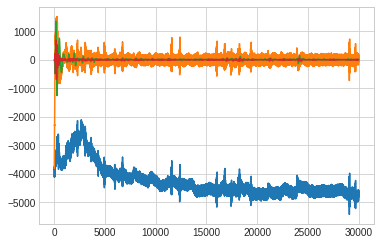

In [45]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
data = scipy.io.loadmat("EEG/EEG_rest.mat")
# data['bands_name']
# data['0_highpass'].shape
# print("a")
plt.plot(data['0'][0][:30000])
plt.plot(data['0_highpass'][0][:30000])
plt.plot(data['0_0_delta_theta'][0][:30000])
plt.plot(data['0_1_alpha'][0][:30000])

In [ ]:
# Save filtered EEG
import os

# path = os.getcwd()
folder_name = f"EEG_rest"

if(os.path.exists(folder_name) == False):
    os.mkdir(folder_name)


scipy.io.savemat()

In [ ]:
# Step2: apply BSS
# TODO 2.1: Run BSS on all channel
# Let's try ILRMA
import pyroomacoustics as pra

## Prepare one-shot STFT
L = 2048
hop = L // 2
win_a = pra.hann(L)
win_s = pra.transform.stft.compute_synthesis_window(win_a, hop)

## STFT ANALYSIS
# (n_samples, n_channels)

X = pra.transform.stft.analysis(np.array(eeg_rest_highpass).T, L, hop, win=win_a)

# Run ILRMA
# We are assuming that our EEG is contaminated with an unknow source from outside the head so there are 16 clean sources + 1 noise 
Y = pra.bss.ilrma(X, n_iter=30, n_components=17, proj_back=True) #callback=convergence_callback)
y = pra.transform.stft.synthesis(Y, L, hop, win=win_s)
# TODO 2.2: Linear Separation Method
# I don't need to perform since ILRMA does not suffer from separation likes ICA
pass

In [ ]:
# For some random reason, I still get 16 outputs
# (293, 1025, 16) (293, 1025, 16) (300032, 16)
# print(X.shape, Y.shape, y.shape)

clean_eeg_rest = y.T

fig,ax = plt.subplots(16, figsize=(16,9*16))

for i in range(16):
    ax[i].plot(eeg_rest_highpass[i], label=f"Original EEG[{i}]")
    ax[i].plot(clean_eeg_rest[i], label=f"ILRMA EEG[{i}]")
    ax[i].set_title(f"EEG Channel {i}")
    ax[i].legend()

plt.show()

In [ ]:
# Step3: Evaluation

# A very naive way to evalute the result is to find the correlation between each channel of EEG signal with all ECoG Channel.
# The set with higher max correlation of each channel is the cleaner result

### ECoG_rest.mat

In [ ]:
path = "dataset/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat"
ecog_rest = scipy.io.loadmat(f'{path}/ECoG_rest.mat')

# dict_keys(['__header__', '__version__', '__globals__', 'ECoG'])
# print(ecog_rest.keys())
# (128, 300000)
# print(ecog_rest['ECoG'].shape)
ecog_rest = ecog_rest['ECoG']

fig, ax = plt.subplots(1, figsize=(16,9))
# Only use 16 because 128 channels break my ipynb
for i in range(16):
    ax.plot(t, ecog_rest[i], label=f"ecog[{i}]")

ax.set_title(f"ECoG in Time Domain")
ax.set_xlabel(f"Time (Second)")
ax.set_ylabel(f"Amplitude (V)")
ax.legend()
plt.show()

In [ ]:
# Seem like we do not need to perform DC removal this time

In [ ]:
# rename for the sake of writing
# make a copy so I don't have to rerun the whole file if I accidentaly overwrite any data
original_eeg = eeg_rest_highpass.copy()
clean_eeg = clean_eeg_rest.copy()
ecog = ecog_rest.copy()

In [ ]:
original_correlation = []
clean_correlation = []
# running one loop of i_eeg takes too much time
for i_eeg in range(len(original_eeg)):
# for i_eeg in range(2):
    channel_original = []
    channel_clean    = []
    for i_ecog in range(len(ecog)):
        c1 = signal.correlate(original_eeg[i_eeg][:1000*10], ecog[i_ecog][:1000*10], mode='full', method='direct')
        c2 = signal.correlate(clean_eeg[i_eeg][:1000*10]   , ecog[i_ecog][:1000*10], mode='full', method='direct')
        channel_original.append(c1)
        channel_clean.append(c2)
        print(i_eeg,i_ecog)
    original_correlation.append(channel_original)
    clean_correlation.append(channel_clean)

In [ ]:
np.array(original_correlation[i]).mean(axis=1).max

In [ ]:
for i in range(len(original_eeg)):
    max_o = np.array(original_correlation[i]).mean(axis=1).max()
    max_c = np.array(clean_correlation[i]).mean(axis=1).max()
    print(max_o, max_c, max_c > max_o)